* Reference: __Enhancing a Pairs Trading strategy with the application of Machine Learning__ _by_ Simão Moraes Sarmento and Nuno Horta


In [6]:
from IPython.display import Image
import pandas as pd
import arbitragelab as al

import warnings
warnings.filterwarnings('ignore')

# Implementation of a Machine Learning based Pairs Selection Framework

## Abstract

In this paper[1], Horta and Sarmento propose a two-stage solution to applying machine learning to the problem of pairs trading. The first stage involves the application of a clustering algorithm to infer any meaningful clusters and using these groups to generate pairs that will be run through a selection process that will supply a list of pairs that comply with the conditions set. 

The second stage should start by training forecasting algorithms to predict the spreads of the selected pairs. Furthermore, decile-based and quintile-based thresholds should be collected to integrate the trading model. Having fitted the forecasting algorithms and obtained the two combinations for the thresholds, the model can be applied to the validation set. From the validation performance, the best threshold combination is selected. At this point, the model is finally ready to be applied on unseen data, from which the performance may be inferred.

## Introduction

This notebook will focus on the first stage, which refers to the pairs selection methodology. It will involve the application of PCA to distill the returns universe into a lower dimensional form. Then the OPTICS algorithm will be applied, on the expectation that it infers meaningful clusters of assets from which to select the pairs. The motivation is to let the data explicitly manifest itself, rather than manually defining the groups each security should belong to. The proposed methodology encompasses the following steps:

- Dimensionality reduction - find a compact representation for each security;
- Unsupervised Learning - apply an appropriate clustering algorithm;
- Select pairs - define a set of rules to select pairs for trading.

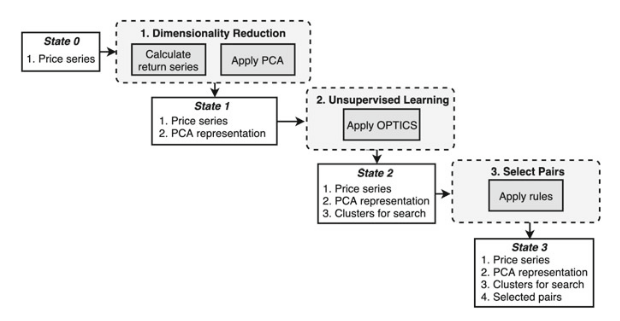

In [2]:
Image(filename='images/prposed_framework_diagram.png') 

---

# Usage of Implementation

To start using this module we first need to set up our asset universe, in this case, the dataset used is the daily price data of every asset in the S&P 500.

In [3]:
prices_df = pd.read_csv('./data/data.csv').set_index('Date').dropna()
prices_df.index = pd.to_datetime(prices_df.index)

prices_df = prices_df.last('10Y')

prices_df.sample(10)

,A,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACN,ADBE,...,XLNX,XOM,XRAY,XRX,XYL,YUM,ZBH,ZBRA,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2018-06-28,61.290001,38.200001,135.110001,46.375000,92.430000,86.099998,413.940002,61.270000,164.500000,239.809998,...,65.129997,81.970001,43.639999,24.129999,66.330002,77.889999,111.269997,143.309998,53.169998,84.830002
2016-10-27,43.380001,39.910000,139.220001,28.620001,61.459999,79.500000,103.320000,40.290001,115.459999,107.070000,...,50.320000,86.919998,55.830002,25.217392,48.029999,61.365925,120.989998,66.330002,32.380001,48.770000
2019-06-24,73.139999,31.820000,152.330002,49.645000,78.449997,83.519997,253.169998,84.709999,186.110001,299.869995,...,112.690002,76.949997,57.669998,34.820000,82.099998,110.660004,117.419998,200.039993,44.119999,113.470001
2015-11-13,36.770000,43.450001,161.619995,28.084999,59.860001,96.589996,80.120003,43.959999,103.150002,89.019997,...,46.540001,78.099998,59.369999,26.561264,35.889999,49.942486,104.290001,67.709999,29.480000,44.849998
2019-11-01,76.970001,30.559999,164.820007,63.955002,81.750000,86.870003,216.789993,82.660004,188.220001,277.820007,...,92.709999,69.599998,55.450001,33.480000,79.120003,99.650002,138.220001,238.000000,49.349998,125.339996
2016-12-22,45.970001,48.689999,170.389999,29.072500,61.660000,77.809998,111.550003,38.290001,117.790001,104.720001,...,60.189999,90.870003,59.130001,23.741766,51.130001,64.050003,101.570000,86.169998,43.740002,53.259998
2018-11-26,69.250000,38.099998,177.720001,43.654999,86.239998,88.940002,311.149994,68.809998,158.399994,231.960007,...,89.010002,76.980003,37.000000,25.840000,69.570000,88.309998,113.250000,169.039993,48.070000,89.519997
2016-11-09,45.939999,42.410000,140.330002,27.719999,62.639999,75.610001,106.019997,40.070000,117.209999,107.860001,...,51.849998,86.250000,61.189999,25.059288,50.660000,61.869999,101.620003,67.150002,34.619999,51.000000
2019-02-22,78.419998,35.490002,161.470001,43.242500,80.019997,85.669998,352.600006,76.129997,161.500000,258.899994,...,122.750000,78.419998,41.630001,31.490000,74.800003,95.389999,124.440002,206.350006,51.169998,94.610001


## Step 1 - Dimensionality Reduction



### Using PCA to find a compact representation for each security

- Extracts common underlying risk factors from securities’ returns;
- Produces a compact representation for each security;

Before applying PCA, the pricing data needs to be converted to returns and then normalized by subtracting the mean and dividing by the standard deviation, as follows:

Returns 

$$ R_{i, t} = \frac{P_{i,t} - P_{i,t-1}} {P_{i,t-1}} $$


Data Normalization

$$ Y_{i} =  \frac{R_{i} - \bar{R_{i}}} {\sigma_{i}} $$

Decomposition

By applying PCA, $A$ is decomposed into the resulting eigenvectors and eigenvalues. An $n$ number of eigenvectors is selected where $n$ represents the number of features to describe the transformed data. The matrix containing the eigenvalues is set as the feature vector. The final dataset is obtained by multiplying the original matrix A by the feature vector.

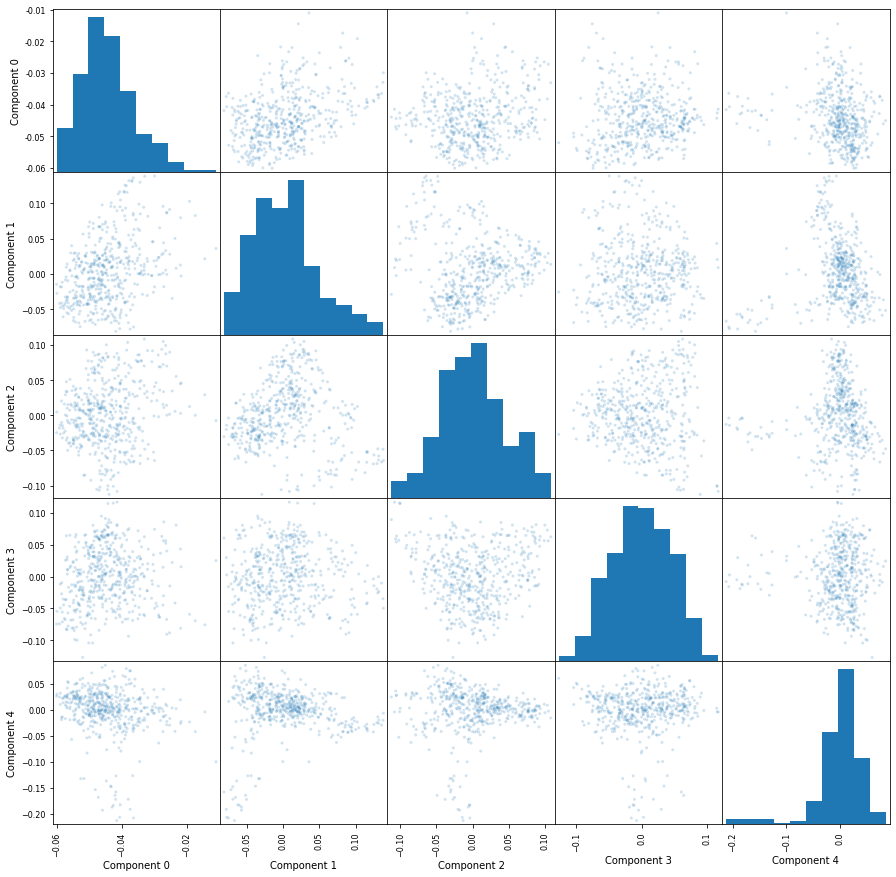

In [4]:
ps = al.ml_approach.PairsSelector(prices_df)

# Here the first parameter is the number of features to reduce to.
ps.dimensionality_reduction_by_components(5)

# The following will plot the feature vector from the previous method call.
ps.plot_pca_matrix();

A quick visual inspection of the feature vector shows a good amount of densely packed groups/clusters. If the points are too sparse, this likely suggests that you don't have enough datapoints.

## Step 2 - Unsupervised Learning
### Applying OPTICS clustering algorithm

- No need to specify the number of clusters in advance;
- Robust to outliers;
- Suitable for clusters with varying density


The first method is to use the OPTICS clustering algorithm and letting the built-in automatic 
procedure to select the most suitable $\epsilon$ for each cluster. 

<IPython.core.display.Javascript object>


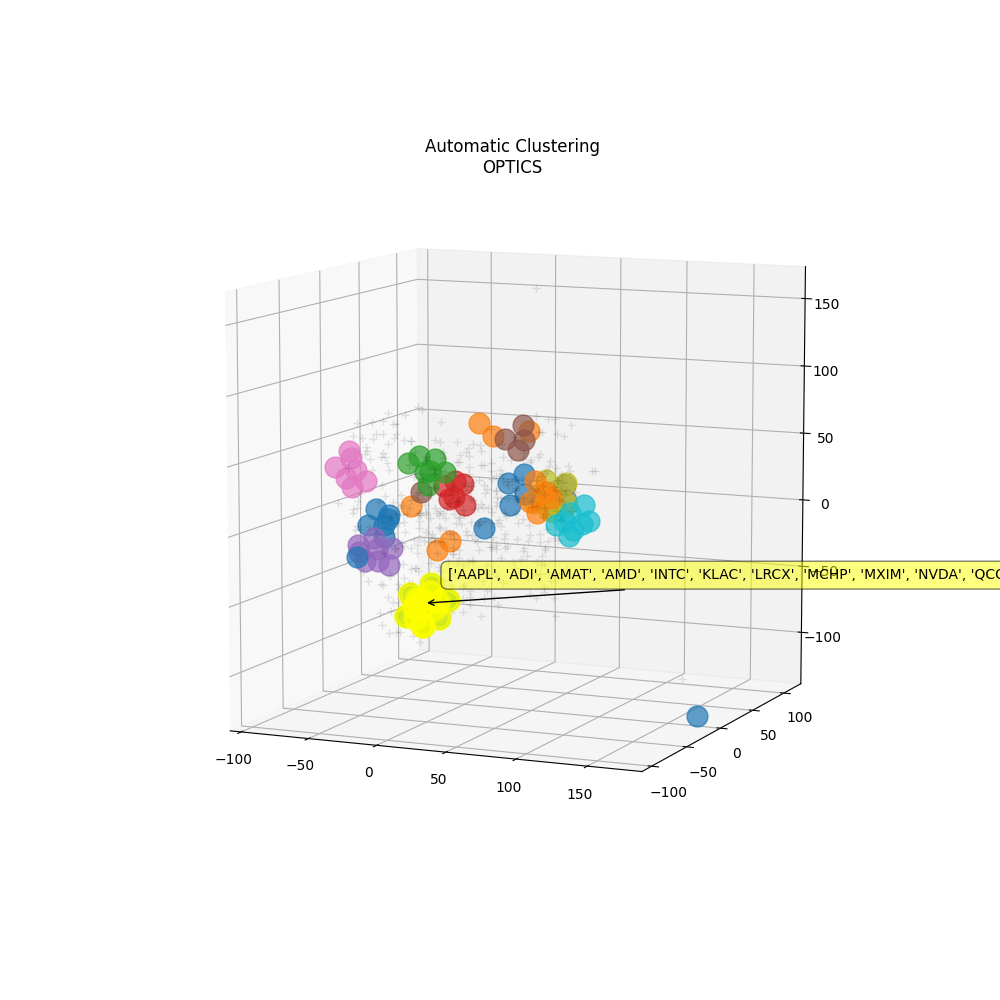

In [18]:
%matplotlib notebook 

ps.cluster_using_optics(min_samples=3)
ps.plot_clustering_info(method='OPTICS', n_dimensions=3);

### Applying DBSCAN clustering algorithm

The second method is to use the DBSCAN clustering algorithm. This is to be used when the user 
has domain-specific knowledge that can enhance the results given the algorithm's parameter 
sensitivity. A possible approach to finding $\epsilon$ described in [2] is to inspect the knee plot and fix a 
suitable $\epsilon$ by observing the global curve turning point.

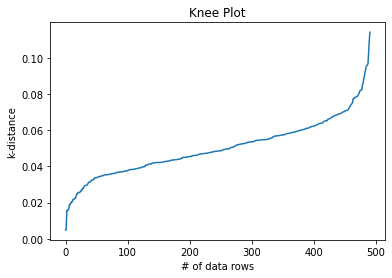

In [17]:
ps.plot_knee_plot();

The following are example results of DBSCAN clustering using different $\epsilon$ values, showing the efficacy of the method at different _'k-distance'_ values from the knee plot. 

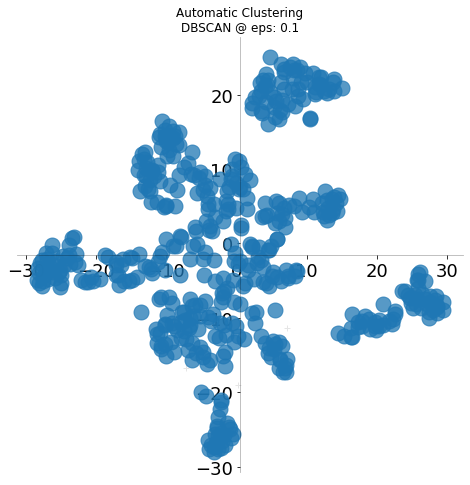

----------------------------------------------------------------------------------------------------


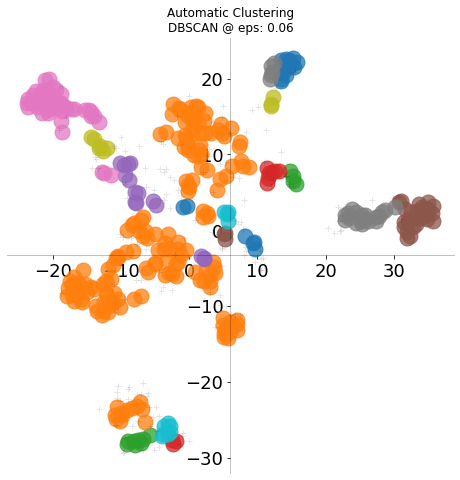

----------------------------------------------------------------------------------------------------


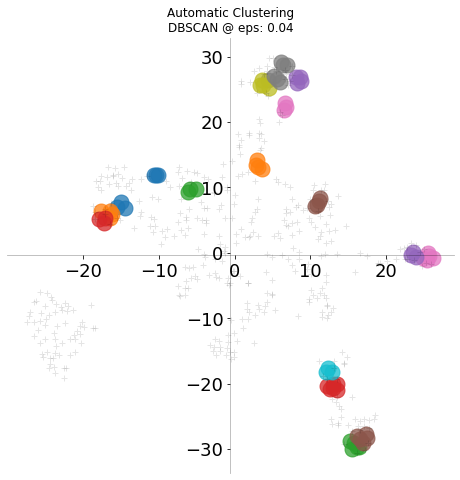

In [23]:
ps.cluster_using_dbscan(eps=0.1, min_samples=3, metric='euclidean')
ps.plot_clustering_info(method='DBSCAN @ eps: 0.1', figsize=(8,8));

print('-' * 100)

ps.cluster_using_dbscan(eps=0.06, min_samples=3, metric='euclidean')
ps.plot_clustering_info(method='DBSCAN @ eps: 0.06', figsize=(8,8));

print('-' * 100)

ps.cluster_using_dbscan(eps=0.04, min_samples=3, metric='euclidean')
ps.plot_clustering_info(method='DBSCAN @ eps: 0.04', figsize=(8,8));

The first plot shows the results with the upper bound value of 0.1, which was not sensitive enough to detect any groups. The second plot was set with the optimal value from the knee plot of 0.06 which detected a good amount of structure. The final plot was set with lower bound value of 0.04, which only managed to detect very densely packed clusters. 

## Step 3 - Select Pairs
### Finding resulting pairs that pass the following set of rules

Sarmento and Horta suggest four criteria to further filter the potential pairs to increase the probability of selecting pairs of securities whose prices will continue to mean revert in the future. 
- Cointegration using the Engle-Granger Test. 
- Hurst Exponent $H$: Keep the pairs with (spread) $H<0.5$ for mean-reversion. 
- Halflife: Keep the pairs with (spread) halflife in between $1$ day and $1$ year.
- Minimum number of crossing mean in a year: Keep the pairs with (spread) crossing its mean $12$ times a year.


These four criteria indicate attractive characteristics for potential tradable pairs of securities. The Engle-Granger tests the pair for cointegration. A Hurst exponent below 0.5 indicates that the pair of prices regresses strongly to the mean. Pairs with extreme half-life values, below 1 or above 356, are excluded from the selected pairs. Extreme half-life values indicate a price series that either reverts too quickly or too slowly to be traded. Finally, the price series must cross the long-term spread mean on average at least 12 times a year.

<div class="alert alert-warning">

**Warning:** The following pairs selection function is computationally heavy, so execution is going to be long and might slow down your system.

</div>


In [5]:
ps.unsupervised_candidate_pair_selector()

Outer Cointegration Loop Progress: |██████████████████████████████████████████████████| 100.0% Complete
Outer OU Loop Progress: |██████████████████████████████████████████████████| 100.0% Complete


array([('AJG', 'ICE'), ('AJG', 'MMC'), ('ICE', 'MMC'), ('MMC', 'WLTW'),
       ('EW', 'FISV'), ('IQV', 'V'), ('NVR', 'PHM'), ('HPE', 'NWS'),
       ('HPE', 'NWSA'), ('NSC', 'UNP'), ('NWS', 'NWSA'), ('AMAT', 'MCHP'),
       ('ATVI', 'EA'), ('AKAM', 'CTXS'), ('CFG', 'FITB'), ('CFG', 'KEY'),
       ('CCI', 'DLR'), ('AWK', 'XEL'), ('ES', 'WEC'), ('FRT', 'REG'),
       ('SLG', 'VNO'), ('APA', 'SLB'), ('EOG', 'MRO')], dtype=object)

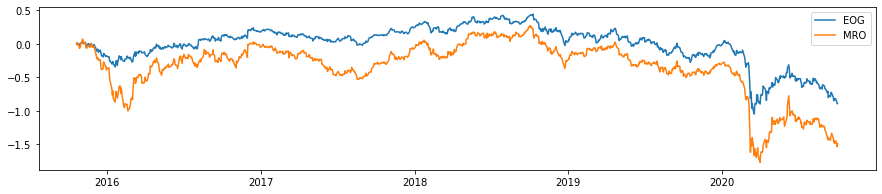

In [7]:
# Helper function to plot a single select pair.
ps.plot_single_pair(('EOG', 'MRO'));

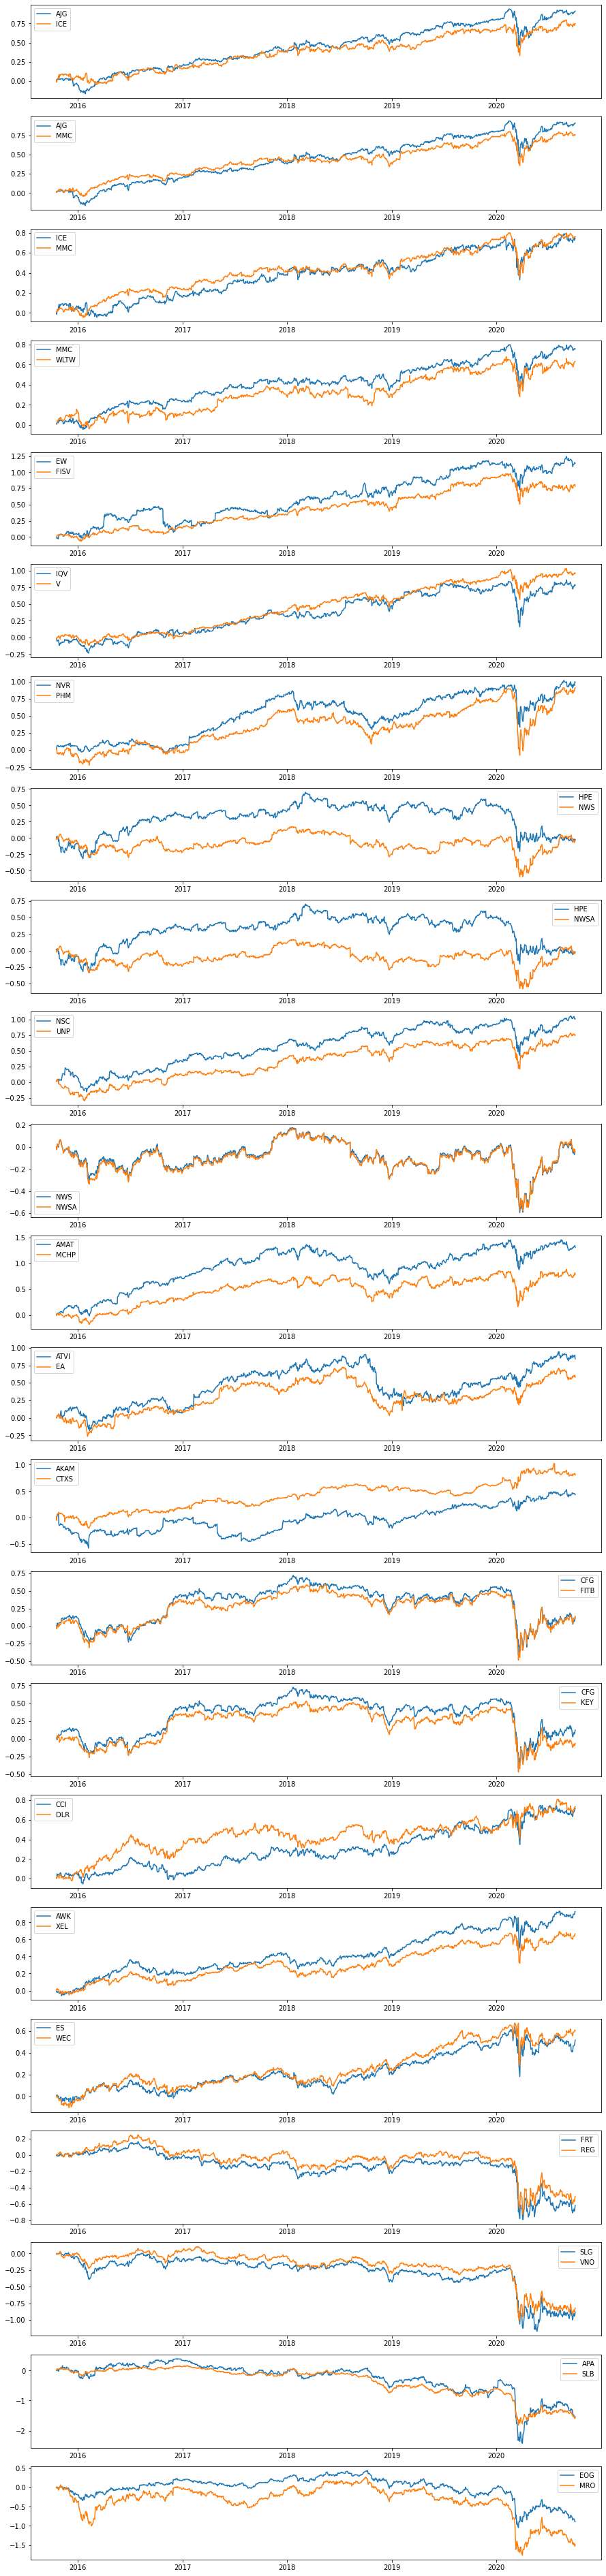

In [7]:
# Helper function to plot all pairs that have passed the final step.
ps.plot_selected_pairs();

In [8]:
# The following method will output detailed pair statistics.
ps.describe_extra()

,leg_1,leg_2,coint_t,pvalue,hedge_ratio,hurst_exponent,half_life,crossovers
0,AJG,ICE,-5.147984,0.000011,0.832406,0.280300,1.178147,True
1,AJG,MMC,-3.984768,0.001492,0.892408,0.333155,1.325405,True
2,ICE,MMC,-4.314326,0.000420,1.072514,0.353929,3.312397,True
3,MMC,WLTW,-4.173535,0.000730,1.758648,0.330393,2.353220,True
4,CHTR,TMUS,-3.834987,0.002569,0.166618,0.350558,2.954012,False
5,EW,FISV,-3.775258,0.003171,1.247778,0.342441,1.774284,True
6,EW,GPN,-4.614576,0.000121,2.381694,0.388706,10.865253,False
7,FISV,GPN,-3.788320,0.003029,1.890617,0.366615,1.021983,False
8,IQV,V,-3.432286,0.009906,1.353333,0.331590,1.975149,True
9,NVR,PHM,-3.553403,0.006717,0.009508,0.389903,13.683387,True


In [9]:
# The following method will output statistics of each step
# done in the framework.
ps.describe()

,0,1
0,No. of Clusters,46
1,Total Pair Combinations,631
2,Pairs passing Coint Test,53
3,Pairs passing Hurst threshold,53
4,Pairs passing Half-Life threshold,32
5,Final Set of Pairs,23


It should be expected that the majority of pairs are eliminated in the first step. Having assets paired up in a cluster doesn't necessarily mean that they are in a long term cointegration.

## Analysis of selected pairs sector/industry classifications


In [10]:
sectoral_info = pd.read_csv('./data/sp500_ticker_sector_info.csv').drop('Unnamed: 0', axis=1)

final_pairs_info = ps.describe_extra()

ps.describe_pairs_sectoral_info(final_pairs_info['leg_1'], final_pairs_info['leg_2'], sectoral_info)

,Leg 1 Ticker,Industry,Sector,Leg 2 Ticker,Industry,Sector
0,AJG,Insurance Brokers,Financial Services,ICE,Financial Data & Stock Exchanges,Financial Services
1,AJG,Insurance Brokers,Financial Services,MMC,Insurance Brokers,Financial Services
2,ICE,Financial Data & Stock Exchanges,Financial Services,MMC,Insurance Brokers,Financial Services
3,MMC,Insurance Brokers,Financial Services,WLTW,Insurance Brokers,Financial Services
4,CHTR,Entertainment,Communication Services,TMUS,Telecom Services,Communication Services
5,EW,Medical Devices,Healthcare,FISV,Information Technology Services,Technology
6,EW,Medical Devices,Healthcare,GPN,Specialty Business Services,Industrials
7,FISV,Information Technology Services,Technology,GPN,Specialty Business Services,Industrials
8,IQV,Diagnostics & Research,Healthcare,V,Credit Services,Financial Services
9,NVR,Residential Construction,Consumer Cyclical,PHM,Residential Construction,Consumer Cyclical


---

# Conclusion

This notebook describes the proposed Pairs Selection Framework also shows example usage of the implemented framework to efficiently reduce the search space and select quality trading pairs. 

- Ten years of daily stock price data for 400 securities were reduced to 5 dimensions through PCA. 
- Over 600 potential trading pairs were identified through OPTICS clustering. 
- Twenty-three pairs from the clusters met the four selection criteria. 

Key takeaways:
- The number of pairs left for a trader to handle is much less compared to the number of pairs generated through an open combinatorial search of the whole asset universe.
- Most of the final pairs selected follow expected economic sectoral clusters even though there was no implied industry/sectoral grouping anywhere in the framework.

Solutions to common pitfalls:
- Dimensionality reduction techniques need a certain amount of data to work reliably, so if instability is encountered at this junction, it is suggested to increase the amount of data.
- The number of PCA components needs to balance the amount of variance represented with density in euclidean distance. The rule of thumb is a number less than 15 components.
- When in doubt use OPTICS.
- For the clustering methods, the _'minimum samples'_ argument needs to be large enough so that the generated clusters are homogeneous. The rule of thumb is a number larger than 3.

# References
1. Sarmento, Simão. & Horta, Nuno. (2020). Enhancing a Pairs Trading strategy with the application of Machine Learning. Available at: http://premio-vidigal.inesc.pt/pdf/SimaoSarmentoMSc-resumo.pdf

2. Rahmah N, Sitanggang S (2016). Determination of Optimal Epsilon (Eps) Value on DBSCAN Algorithm to Clustering Data on Peatland Hotspots in Sumatra. Available at: https://doi.org/10.1088/1755-1315/31/1/012012